In [0]:
# https://www.datacamp.com/courses/advanced-deep-learning-with-keras-in-python

Modules to import

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import unique

from keras.layers import Input, Dense, Embedding, Flatten
from keras.layers import Concatenate, Subtract
from keras.models import Model
from keras.utils import plot_model
from keras.optimizers import Adam

from scipy.special import expit as sigmoid

Using TensorFlow backend.


In [0]:
# to export dataframe

print(df.to_string())

In [0]:
# to display entire numpy array

numpy.set_printoptions(threshold=numpy.inf)

In [0]:
games_season = pd.read_csv('/content/games_season.csv')
games_season.shape # (312178, 8)

(312178, 8)

In [0]:
games_tourney = pd.read_csv("/content/games_tourney.csv")
games_tourney.shape # (4234, 9)

(4234, 9)

## 1. The Keras Functional API

#### Keras input and dense layers

In [0]:
# Import Input from keras.layers
from keras.layers import Input

Using TensorFlow backend.


In [0]:
# Create an input layer of shape 1
input_tensor = Input(shape=(1,))

**Dense layers**

Once you have an Input layer, the next step is to add a Dense layer.

Dense layers learn a weight matrix, where the first dimension of the matrix is the dimension of the input data, and the second dimension is the dimension of the output data. Recall that your Input layer has a shape of 1. In this case, your output layer will also have a shape of 1. This means that the Dense layer will learn a 1x1 weight matrix.

In this exercise, you will add a dense layer to your model, after the input layer.

In [0]:
# Load layers
from keras.layers import Input, Dense

In [0]:
# Input layer (from previous exercise)
input_tensor = Input(shape=(1,))

# Create a dense layer
output_layer = Dense(1)

# Connect the dense layer to the input_tensor
output_tensor = output_layer(input_tensor)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Load layers
from keras.layers import Input, Dense

# Input layer
input_tensor = Input(shape=(1,))

# Create a dense layer and connect the dense layer to the input_tensor in one step
# Note that we did this in 2 steps in the previous exercise, but are doing it in one step now
output_tensor = Dense(1)(input_tensor)

#### Build and compile a model

In [0]:
from keras.models import Model

In [0]:
# Build the model
model = Model(input_tensor, output_tensor)

In [0]:
# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [0]:
# Import the plotting function
from keras.utils import plot_model
import matplotlib.pyplot as plt

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


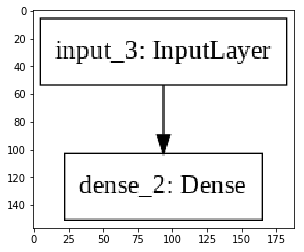

In [0]:
# Summarize the model
model.summary()

# Plot the model
plot_model(model, to_file='model.png')

# Display the image
data = plt.imread('model.png')
plt.imshow(data)
plt.show()

#### Fit and evaluate a model

In [0]:
games_tourney_train = pd.read_csv("/content/games_tourney_train.csv")

In [0]:
games_tourney_test = pd.read_csv("/content/games_tourney_test.csv")

In [0]:
games_tourney_train.shape # (3430, 9)

(3430, 9)

In [0]:
games_tourney_test.shape # (804, 9)

(804, 9)

In this exercise, you'll use a dataset of scores from US College Basketball tournament games. Each row of the dataset has the team ids: `team_1` and `team_2`, as integers. It also has the seed difference between the teams (seeds are assigned by the tournament committee and represent a ranking of how strong the teams are) and the score difference of the game (e.g. if `team_1` wins by 5 points, the score difference is 5).

To fit the model, you provide a matrix of X variables (in this case one column: the seed difference) and a matrix of Y variables (in this case one column: the score difference).

The `games_tourney` DataFrame along with the compiled model object is available in your workspace.

In [0]:
# Now fit the model
model.fit(games_tourney_train['seed_diff'], games_tourney_train['score_diff'],
          epochs=1,
          batch_size=128,
          validation_split=0.10,
          verbose=True)

Instructions for updating:
Use tf.cast instead.
Train on 3087 samples, validate on 343 samples
Epoch 1/1
3087/3087 [==============================] - 0s 42us/step - loss: 15.0308 - val_loss: 14.0304


In [0]:
# Load the X variable from the test data
X_test = games_tourney_test['seed_diff']

# Load the y variable from the test data
y_test = games_tourney_test['score_diff']

In [0]:
# Evaluate the model on the test data
model.evaluate(X_test, y_test)

804/804 [==============================] - 0s 30us/step


14.096755981445312

## 2. Two Input Network 
### using categorical embeddings, shared layers, and merge layers

#### Category embeddings

In [0]:
# Imports
from keras.layers import Embedding
from numpy import unique

Shared layers allow a model to use the same weight matrix for multiple steps. In this exercise, you will build a "team strength" layer that represents each team by a single number. You will use this number for both teams in the model. 

The model will learn a number for each team that works well both when the team is team_1 and when the team is team_2 in the input data.

In [0]:
games_season = pd.read_csv('/content/games_season.csv')
games_season.shape # (312178, 8)

(312178, 8)

In [0]:
# Count the unique number of teams
n_teams = unique(games_season['team_1']).shape[0]

In [0]:
# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

The embedding layer is a lot like a dictionary, but your model learns the values for each key.

**Define team model**

The team strength lookup has three components: an input, an embedding layer, and a flatten layer that creates the output.

If you wrap these three layers in a model with an input and output, you can re-use that stack of three layers at multiple places.

Note again that the weights for all three layers will be shared everywhere we use them.

In [0]:
# Imports
from keras.layers import Input, Embedding, Flatten
from keras.models import Model

In [0]:
# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

Instructions for updating:
Colocations handled automatically by placer.


#### Shared layers

**Defining two inputs**

In this exercise, you will define two input layers for the two teams in your model. This allows you to specify later in the model how the data from each team will be used differently.

In [0]:
# Input layer for team 1
team_in_1 = Input(shape=(1,), name='Team-1-In')

# Separate input layer for team 2
team_in_2 = Input(shape=(1,), name='Team-2-In')

In [0]:
# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

#### Merge layers

**Output layer using shared layer**

Now that you've looked up how "strong" each team is, subtract the team strengths to determine which team is expected to win the game.

The subtract layer will combine the weights from the two layers by subtracting them.

In [0]:
# Import the Subtract layer from keras
from keras.layers import Subtract

In [0]:
# Create a subtract layer using the inputs from the previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])



*   Define a model with the two teams as inputs and use the score difference as the output.
*   Compile the model with the 'adam' optimizer and 'mean_absolute_error' loss.



In [0]:
from keras.models import Model

In [0]:
# Subtraction layer from previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

#### Predict from your model

Since your model has two inputs now, you need to pass the input data as a list.

In [0]:
# Get the team_1 column from the regular season data
input_1 = games_season['team_1']

# Get the team_2 column from the regular season data
input_2 = games_season['team_2']



*  Assign the 'team_1' and 'team_2' columns from games_season to input_1 and input_2, respectively.
*   Use 'score_diff' column from games_season as the target.
*   Fit the model using 1 epoch, a batch size of 2048, and a 10% validation split.



In [0]:
# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1, input_2],
          games_season['score_diff'],
          epochs=1,
          batch_size=2048,
          validation_split=0.10,
          verbose=True)

Instructions for updating:
Use tf.cast instead.
Train on 280960 samples, validate on 31218 samples
Epoch 1/1
280960/280960 [==============================] - 0s 2us/step - loss: 12.1201 - val_loss: 11.8379


In this exercise, you will evaluate the model on this new dataset. This evaluation will tell you how well you can predict the tournament games, based on a model trained with the regular season data. 


In [0]:
games_tourney = pd.read_csv("/content/games_tourney.csv")
games_tourney.shape # (4234, 9)

(4234, 9)

In [0]:
# Get team_1 from the tournament data
input_1 = games_tourney['team_1']

# Get team_2 from the tournament data
input_2 = games_tourney['team_2']

# Evaluate the model using these inputs
model.evaluate([input_1, input_2], games_tourney['score_diff'])

4234/4234 [==============================] - 0s 19us/step


11.680718848544243

## 3. Multiple Inputs: 3 Inputs (and Beyond!)

#### Three-input models

In [0]:
from keras.layers import Concatenate

In [0]:
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

In [0]:
# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

In [0]:
# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

In [0]:
# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

In [0]:
# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [0]:
# Fit the model to the games_season dataset
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1,
          verbose=True,
          validation_split=.10,
          batch_size=2048)

Train on 280960 samples, validate on 31218 samples
Epoch 1/1
280960/280960 [==============================] - 1s 2us/step - loss: 12.1281 - val_loss: 12.0450


In [0]:
# Evaluate the model on the games_tourney dataset
model.evaluate([games_tourney['team_1'], 
                games_tourney['team_2'], 
                games_tourney['home']], 
               games_tourney['score_diff'])

4234/4234 [==============================] - 0s 20us/step


11.68964503697759

#### Summarizing and plotting models

In [0]:
# Imports
import matplotlib.pyplot as plt
from keras.utils import plot_model

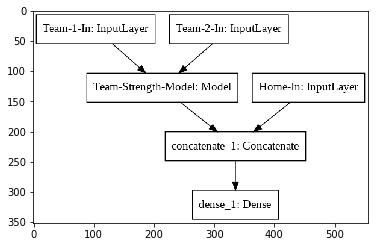

In [0]:
# Plot the model
plot_model(model, to_file='model.png')

# Display the image
data = plt.imread('model.png')
plt.imshow(data)
plt.show()

#### Stacking models

You'll use the prediction from the regular season model as an input to the tournament model. This is a form of "model stacking."

To start, take the regular season model from the previous lesson, and predict on the tournament data. Add this prediction to the tournament data as a new column.

In [0]:
# Predict
games_tourney['pred'] = model.predict([games_tourney['team_1'], 
                                             games_tourney['team_2'], 
                                             games_tourney['home']])

Now you have three numeric columns in the tournament dataset: '`seed_diff`', '`home`', and '`pred`'. In this exercise, you will create a neural network that uses a single input layer to process all three of these numeric inputs.

In [0]:
# Create an input layer with 3 columns
input_tensor = Input((3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

Tournament games are split into a training set and a test set. The tournament games before 2010 are in the training set, and the ones after 2010 are in the test set.

*   Fit the model to the games_tourney_train dataset using 1 epoch.
*   The input columns are 'home', 'seed_diff', and 'pred'.
*   The target column is 'score_diff'.



In [0]:
games_tourney_train = games_tourney[:3430]
games_tourney_train.tail()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won,pred
3425,2011,667,10690,0,-9,-14,58,72,0,0.105038
3426,2011,1039,10690,0,-4,7,61,54,1,0.106724
3427,2011,4209,10690,0,-1,-5,65,70,0,0.166182
3428,2011,1073,10713,0,11,8,74,66,1,0.151377
3429,2011,4899,10812,0,-5,11,66,55,1,0.104264


In [0]:
games_tourney_train.shape # (3430, 10)

(3430, 10)

In [0]:
# Fit the model
model.fit(games_tourney_train[['home', 'seed_diff', 'pred']],
          games_tourney_train['score_diff'],
          epochs=1,
          verbose=True)

Epoch 1/1
3430/3430 [==============================] - 0s 66us/step - loss: 9.1609


In [0]:
games_tourney_test = games_tourney[3430:]
games_tourney_test.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won,pred
3430,2012,1907,100,0,1,1,58,57,1,0.140155
3431,2012,1704,649,0,-8,-17,63,80,0,0.175183
3432,2012,4291,649,0,2,12,82,70,1,0.163649
3433,2012,7533,649,0,-11,-8,60,68,0,0.191677
3434,2012,10813,649,0,-7,-5,70,75,0,0.161060


In [0]:
model.evaluate(games_tourney_test[['home', 'seed_diff', 'pred']], 
               games_tourney_test['score_diff'])

804/804 [==============================] - 0s 64us/step


9.204197300014211

## 4. Multiple Outputs

#### Two-output model

In this exercise, you will use the tournament data to build one model that makes two predictions: the scores of both teams in a given game. Your inputs will be the seed difference of the two teams, as well as the predicted score difference from the model you built in chapter 3.

The output from your model will be the predicted score for team 1 as well as team 2. This is called "multiple target regression": one model making more than one prediction.

In [0]:
# Define the input
input_tensor = Input((2,))

# Define the output
output_tensor = Dense(2)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')



*   Fit the model to the games_tourney_train dataset using 100 epochs and a batch size of 16384.

*   The input columns are 'seed_diff', and 'pred'.

*   The target columns are 'score_1' and 'score_2'.





In [0]:
# Fit the model
model.fit(games_tourney_train[['seed_diff', 'pred']],
  		  games_tourney_train[['score_1', 'score_2']],
  		  verbose=True,
  		  epochs=100,
  		  batch_size=16384)

Epoch 1/100
3430/3430 [==============================] - 0s 2us/step - loss: 71.1375
Epoch 2/100
3430/3430 [==============================] - 0s 2us/step - loss: 71.1363
Epoch 3/100
3430/3430 [==============================] - 0s 2us/step - loss: 71.1352
Epoch 4/100
3430/3430 [==============================] - 0s 1us/step - loss: 71.1340
Epoch 5/100
3430/3430 [==============================] - 0s 1us/step - loss: 71.1329
Epoch 6/100
3430/3430 [==============================] - 0s 1us/step - loss: 71.1318
Epoch 7/100
3430/3430 [==============================] - 0s 1us/step - loss: 71.1306
Epoch 8/100
3430/3430 [==============================] - 0s 1us/step - loss: 71.1295
Epoch 9/100
3430/3430 [==============================] - 0s 1us/step - loss: 71.1284
Epoch 10/100
3430/3430 [==============================] - 0s 1us/step - loss: 71.1272
Epoch 11/100
3430/3430 [==============================] - 0s 2us/step - loss: 71.1261
Epoch 12/100
3430/3430 [==============================] - 0s 2u

Now that you've fit your model, let's take a look at it. You can use the .get_weights() method to inspect your model's weights.

The input layer will have 4 weights: 2 for each input times 2 for each output.

The output layer will have 2 weights, one for each output.

In [0]:
# Print the model's weights
print(model.get_weights())

[array([[-0.70227855, -0.4406793 ],
       [ 1.2666051 ,  0.15003994]], dtype=float32), array([0.5007364, 0.5007364], dtype=float32)]


In [0]:
# Print the column means of the training data
print(games_tourney_train.mean())

season        1998.074052
team_1        5556.771429
team_2        5556.771429
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.621283
score_2         71.621283
won              0.500000
pred             0.136735
dtype: float64


Now that you've fit your model and inspected it's weights to make sure it makes sense, evaluate it on the tournament test set to see how well it performs on new data.

In [0]:
model.evaluate(games_tourney_test[['seed_diff', 'pred']],
               games_tourney_test[['score_1', 'score_2']])

804/804 [==============================] - 0s 72us/step


68.44189790943962

#### Single model for classification and regression

 This time, you will predict the score difference, instead of both team's scores and then you will predict the probability that team 1 won the game. 
 
 This is a pretty cool model: it is going to do both classification and regression!
 
 In this model, **turn off the bias, or intercept for each layer**. Your inputs (seed difference and predicted score difference) have a mean of very close to zero, and your outputs both have means that are close to zero, so your model shouldn't need the bias term to fit the data well.

In [0]:
# Create an input layer with 2 columns
input_tensor = Input((2,))

# Create the first output
output_tensor_1 = Dense(1, activation='linear', use_bias=False)(input_tensor)

# Create the second output (use the first output as input here)
output_tensor_2 = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_1)

# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1, output_tensor_2])

In [0]:
# Import the Adam optimizer
from keras.optimizers import Adam

Compile the model with 2 losses: 'mean_absolute_error' and 'binary_crossentropy', and use the Adam optimizer with a learning rate of 0.01.

In [0]:
# Compile the model with 2 losses and the Adam optimzer with a higher learning rate
model.compile(loss=['mean_absolute_error', 'binary_crossentropy'], optimizer=Adam(lr=0.01))

Fit the model with 'seed_diff' and 'pred' columns as the inputs and 'score_diff' and 'won' columns as the targets.

In [0]:
# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(games_tourney_train[['seed_diff', 'pred']],
          [games_tourney_train[['score_diff']], games_tourney_train[['won']]],
          epochs=10,
          verbose=True,
          batch_size=16384)

Epoch 1/10
3430/3430 [==============================] - 0s 70us/step - loss: 12.7283 - dense_4_loss: 10.3674 - dense_5_loss: 2.3609
Epoch 2/10
3430/3430 [==============================] - 0s 1us/step - loss: 12.6984 - dense_4_loss: 10.3890 - dense_5_loss: 2.3094
Epoch 3/10
3430/3430 [==============================] - 0s 2us/step - loss: 12.6649 - dense_4_loss: 10.4140 - dense_5_loss: 2.2509
Epoch 4/10
3430/3430 [==============================] - 0s 2us/step - loss: 12.6310 - dense_4_loss: 10.4410 - dense_5_loss: 2.1900
Epoch 5/10
3430/3430 [==============================] - 0s 2us/step - loss: 12.5977 - dense_4_loss: 10.4692 - dense_5_loss: 2.1285
Epoch 6/10
3430/3430 [==============================] - 0s 1us/step - loss: 12.5655 - dense_4_loss: 10.4983 - dense_5_loss: 2.0672
Epoch 7/10
3430/3430 [==============================] - 0s 1us/step - loss: 12.5347 - dense_4_loss: 10.5280 - dense_5_loss: 2.0067
Epoch 8/10
3430/3430 [==============================] - 0s 2us/step - loss: 12.505

In [0]:
# Print the model's weights
print(model.get_weights())

[array([[ 0.31350645],
       [-0.4308766 ]], dtype=float32), array([[-0.9753931]], dtype=float32)]


In [0]:
# Print the column means of the training data
print(games_tourney_train.mean())

season        1998.074052
team_1        5556.771429
team_2        5556.771429
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.621283
score_2         71.621283
won              0.500000
pred             0.136735
dtype: float64


In [0]:
# Import the sigmoid function from scipy
from scipy.special import expit as sigmoid

In [0]:
# Weight from the model
weight = 0.14

In particular, note the last weight of the model. This weight converts the predicted score difference to a predicted win probability. If you multiply the predicted score difference by the last weight of the model and then apply the sigmoid function, you get the win probability of the game.

In [0]:
# Print the approximate win probability of a predicted close game
print(sigmoid(1 * weight))

0.5349429451582145


In [0]:
# Print the approximate win probability of a predicted blowout game
print(sigmoid(10 * weight))

0.8021838885585818


So sigmoid(1 * 0.14) is 0.53, which represents a pretty close game and sigmoid(10 * 0.14) is 0.80, which represents a pretty likely win. In other words, if the model predicts a win of 1 point, it is less sure of the win than if it predicts 10 points. Who says neural networks are black boxes?

In [0]:
# Evaluate the model on new data
model.evaluate(games_tourney_test[['seed_diff', 'pred']],
               [games_tourney_test[['score_diff']], games_tourney_test[['won']]])

804/804 [==============================] - 0s 95us/step


[11.968475550561402, 10.283499997646654, 1.684975550245883]